# Random Forest - Top model according to the SCPM of -5 and dominance count 19

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
# Database Reading and Manipulation
import pandas as pd

# Linear Algebra
import numpy as np

# Plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

# Modeling
from sklearn.ensemble import RandomForestRegressor

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# Processing
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import Pipeline

# Data imputation
from sklearn.impute import SimpleImputer

# Custom modules
## Model selection
from src.cross_validation.blocking_time_series_split import BlockingTimeSeriesSplit

## Function to print scores
from src.utils.print_scores import print_scores

## Function to calculate score regression metrics
from src.utils.score_regression_metrics import score_regression_metrics

## Function to fill the results metric dict
from src.utils.fill_results_dict import fill_results_dict

# Warnings
import warnings

<IPython.core.display.Javascript object>

# Functions and definitions

In [3]:
def get_random_forest_df_importances(scores):
    importances = {}
    importances_with_column = []
    columns = x.columns

    for index, pipeline in enumerate(scores["estimator"]):
        model = pipeline.named_steps["estimator"]
        importances[index] = model.feature_importances_

    for index, importances_vec in importances.items():
        importances_col = pd.DataFrame(
            {col: [c] for col, c in zip(columns, importances_vec)},
            index=[f"Importances - {index}"],
        )
        importances_with_column.append(importances_col)
    df_importances = pd.concat(importances_with_column)

    return df_importances

<IPython.core.display.Javascript object>

In [4]:
SEED = 47
METRICS = (
    "neg_root_mean_squared_error",
    "neg_mean_absolute_error",
    "neg_mean_absolute_percentage_error",
    "r2",
)
METRICS_DICT = {
    "neg_root_mean_squared_error": "RMSE",
    "neg_mean_absolute_error": "MAE",
    "neg_mean_absolute_percentage_error": "MAPE",
    "r2": "R2",
}

<IPython.core.display.Javascript object>

## Defining a dataframe structure to save the results

In [5]:
results_to_save = []

results_dict = {
    "Category": "Local Model",
    "Company": "207",
    "Plant": "AT",
    "Features": "Chemical + Physical",
    "Data Shape": None,
    "Timesteps": None,
    "Model": "Random Forest",
    "Model Params": None,
    "Scaler": None,
    "Scaler Params": None,
    "Imputer": "Median",
    "Imputer Params": None,
    "Cross Validation": None,
    "Cross Validation Params": np.nan,
    "RMSE Train": np.nan,
    "MAE Train": np.nan,
    "MAPE Train": np.nan,
    "R2 Train": np.nan,
    "RMSE Test": np.nan,
    "MAE Test": np.nan,
    "MAPE Test": np.nan,
    "R2 Test": np.nan,
}

<IPython.core.display.Javascript object>

# Reading the dataset

In [6]:
df = pd.read_csv("../../../../data/processed/207/at.csv")

<IPython.core.display.Javascript object>

## Defining Features

In this set of experiments we keep only chemical and mineralogical features yielded by the same testing method/procedure

In [7]:
df_copy = df.copy().drop(
    [
        "Cement_Type",
        "Blaine",
        "#200",
        "#400",
        "Final setting time",
        "Initial setting time",
        "CS3",
        "CS7",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

# 1. Decision Tree Regressor

In [8]:
PARAMS = {
    "criterion": "squared_error",
    "n_estimators": 5,
    "max_depth": 3,
    "random_state": SEED,
}

<IPython.core.display.Javascript object>

<h2>1. Dataset: df_no_cs</h2> <br>In this dataset the CS1, CS3  and CS7 variables are not considered. Only Chemical and mineralogical features measured by the same method. For this particular dataset, all chemical features, with the exception of LOI were measured by XRF and XRD methods.

In [9]:
y = df_copy.pop("CS28").values
x = df_copy.drop(["Date"], axis=1)
dates = df["Date"].copy()

<IPython.core.display.Javascript object>

## 1.2. Blocking Time Series Cross Validation

<b>Dataset shape:</b> (1234, 38)<br>
<b>Splits:</b>5<br>    
    1. 5 folds of 246 samples
    2. 50% train (123 samples each fold)
    3. 50% test (123 samples each fold)
<b>Total:</b> 5 models<br>

In [10]:
repeats = 3
n_splits = 5
train_size = 0.8

pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("estimator", RandomForestRegressor(**PARAMS)),
    ]
)
cv = BlockingTimeSeriesSplit(n_splits=n_splits, train_size=train_size)
scores = cross_validate(
    pipeline,
    x,
    y,
    scoring=METRICS,
    cv=cv,
    n_jobs=-1,
    return_train_score=True,
    return_estimator=True,
    return_indices=True,
)
print("Blocking Time Series Split:")
print(f"Repeats: {repeats}")
print(f"n_splits: {n_splits}")
print()
print_scores(scores, METRICS, METRICS_DICT)

results_dict_copy = results_dict.copy()
results_dict_copy["Cross Validation"] = "Blocking Time Series Split"
results_dict_copy[
    "Cross Validation Params"
] = '{"N_Splits": 5, "Repeats": 1, "train_size": 0.8}'
results_dict_copy["Data Shape"] = x.shape
df_results = fill_results_dict(results_dict_copy, scores)
results_to_save.append(df_results)

Blocking Time Series Split:
Repeats: 3
n_splits: 5

******
[TRAIN]
******
RMSE: -1.541 (0.137)
MAE: -1.222 (0.127)
MAPE: -0.027 (0.003)
R2: 0.614 (0.177)


******
[TEST]
******
RMSE: -1.957 (0.389)
MAE: -1.607 (0.326)
MAPE: -0.036 (0.006)
R2: 0.360 (0.431)




<IPython.core.display.Javascript object>

## Plotting the Predictions

In [11]:
df_pred = pd.DataFrame()
df_pred["DATE"] = dates.copy()
df_pred["CS28"] = y.copy()
df_pred["CS28_PRED"] = np.nan
df_pred["SET"] = ""
df_pred["CEMENT_TYPE"] = df["Cement_Type"].copy()
df_pred["DATE"] = pd.to_datetime(df_pred["DATE"])


for idx, pipeline in enumerate(scores["estimator"]):
    index_train = scores["indices"]["train"][idx]
    index_test = scores["indices"]["test"][idx]
    index_preds = np.concatenate([index_train, index_test])

    # results = scores["estimator"][0].predict(x.loc[index_preds])
    results = pipeline.predict(x.loc[index_preds])
    df_pred.loc[index_preds, "CS28_PRED"] = results.copy()
    df_pred.loc[index_train, "SET"] = "TRAIN"
    df_pred.loc[index_test, "SET"] = "TEST"
df_pred = df_pred.dropna()

<IPython.core.display.Javascript object>

In [12]:
df_pred

,DATE,CS28,CS28_PRED,SET,CEMENT_TYPE
0,2021-01-01,41.400002,43.952732,TRAIN,CPIII40
1,2021-01-01,33.500000,35.348444,TRAIN,CPIIF32
2,2021-01-02,42.900002,45.462335,TRAIN,CPVARI
3,2021-01-04,44.900002,46.245131,TRAIN,CPVARI
4,2021-01-04,41.500000,44.228931,TRAIN,CPIII40
...,...,...,...,...,...
1720,2023-09-20,44.299999,45.878411,TEST,CPIII40
1721,2023-09-21,47.799999,45.878411,TEST,CPVARI
1722,2023-09-21,44.299999,45.878411,TEST,CPIII40
1723,2023-09-22,44.299999,45.878411,TEST,CPIII40


<IPython.core.display.Javascript object>

In [13]:
# df_copy_merge = df_copy.merge(df_pred, left_index=True, right_index=True, how="left")
# df_copy_merge["COMPANY"] = 209
# df_copy_merge["PLANT"] = "S"
# for fold, (train_index, test_index) in enumerate(cv.split(x)):
#     df_copy_merge.loc[train_index, "FOLD"] = fold + 1
#     df_copy_merge.loc[test_index, "FOLD"] = fold + 1
# df_copy_merge["FOLD"] = df_copy_merge["FOLD"].astype(int)
# df_copy_merge.to_excel("local_model_random_forest_btsscv_209_s.xlsx", index=False)
# df_copy_merge.to_csv("local_model_random_forest_btsscv_209_s.csv", index=False)

<IPython.core.display.Javascript object>

In [14]:
matplotlib.rc_file_defaults()

<IPython.core.display.Javascript object>

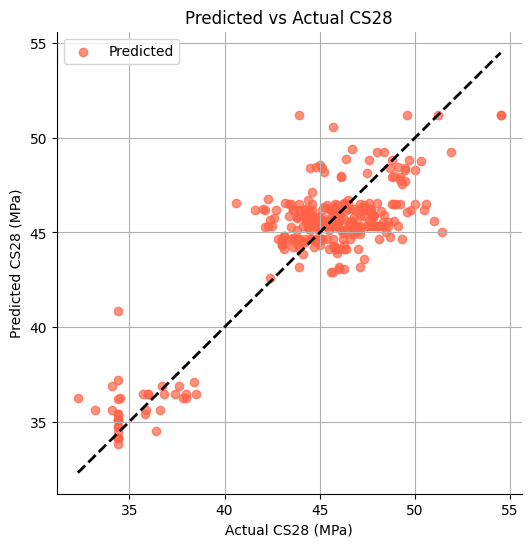

<IPython.core.display.Javascript object>

In [15]:
test_data = df_pred[df_pred["SET"] == "TEST"]

plt.figure(figsize=(6, 6))
plt.scatter(
    test_data["CS28"], test_data["CS28_PRED"], color="tomato", alpha=0.7, label="Predicted"
)
plt.plot(
    [test_data["CS28"].min(), test_data["CS28"].max()],
    [test_data["CS28"].min(), test_data["CS28"].max()],
    color="black", linestyle="--", linewidth=2,
)
plt.xlabel("Actual CS28 (MPa)")
plt.ylabel("Predicted CS28 (MPa)")
plt.title("Predicted vs Actual CS28")
plt.legend()
plt.grid(True)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig("ecics_207_at_cm_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
df["Cement_Type"].value_counts()

Cement_Type
CPIII40    814
CPVARI     781
CPIIF32    134
Name: count, dtype: int64

<IPython.core.display.Javascript object>

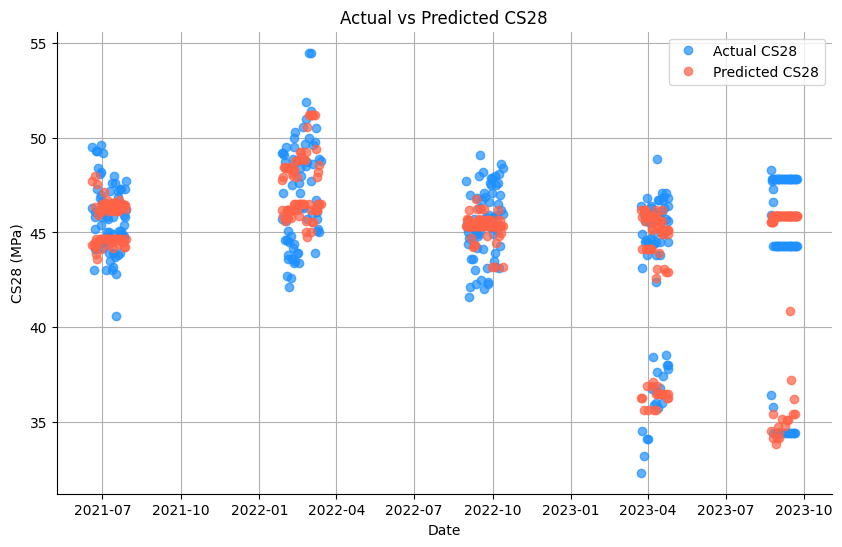

<IPython.core.display.Javascript object>

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(
    test_data["DATE"],
    test_data["CS28"],
    color="dodgerblue",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Actual CS28",
)
plt.plot(
    test_data["DATE"],
    test_data["CS28_PRED"],
    color="tomato",
    alpha=0.7,
    marker="o",
    linestyle="none",
    label="Predicted CS28",
)
plt.xlabel("Date")
plt.ylabel("CS28 (MPa)")
plt.title("Actual vs Predicted CS28")
plt.legend(loc="best")
plt.grid(True)

plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)

plt.savefig(
    "ecics_207_at_cm_btiss_scpm_top_one_random_forest_pred_vs_actual_cs28_over_time.png",
    dpi=300,
    bbox_inches="tight",
)

plt.show()


## Assessing Feature Importance

In [18]:
df_importances = get_random_forest_df_importances(scores)

<IPython.core.display.Javascript object>

In [19]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Specific Gravity
Importances - 0,0.017002,0.031423,0.031450,0.072181,0.019127,0.586354,0.144069,0.031816,0.021154,0.028921,0.016502
Importances - 1,0.048212,0.020618,0.014737,0.000000,0.000000,0.700092,0.031829,0.038289,0.076965,0.045658,0.023601
Importances - 2,0.056154,0.296211,0.006245,0.059375,0.090180,0.092151,0.118681,0.013789,0.241178,0.000000,0.026037
Importances - 3,0.108099,0.041273,0.000000,0.000663,0.004998,0.003852,0.003968,0.049032,0.775498,0.012546,0.000072
Importances - 4,0.005787,0.012643,0.000000,0.000000,0.007311,0.000000,0.005261,0.033909,0.929651,0.005438,0.000000


<IPython.core.display.Javascript object>

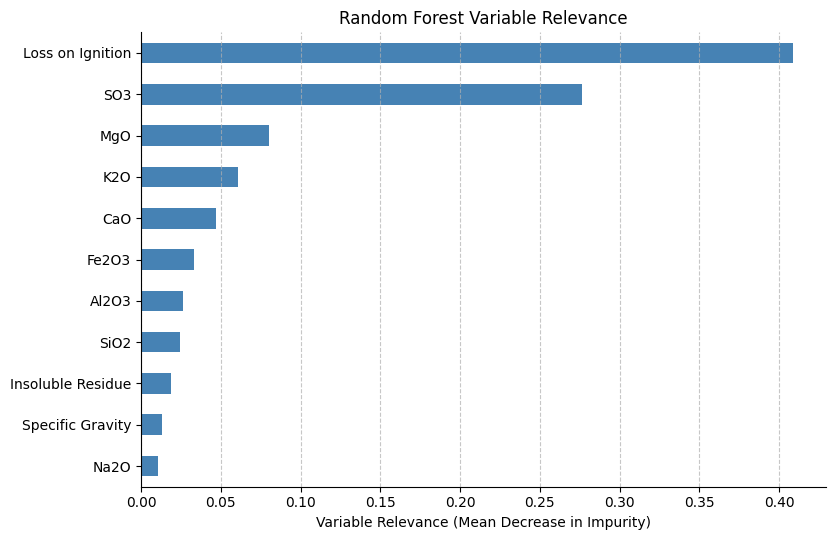

<IPython.core.display.Javascript object>

In [20]:
df_importances.mean(axis=0).sort_values().plot(
    kind="barh", figsize=(10, 5.5), color="steelblue"  # Consider using 'steelblue'
)
plt.title("Random Forest Variable Relevance")
plt.xlabel("Variable Relevance (Mean Decrease in Impurity)")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.tight_layout()
plt.subplots_adjust(left=0.3)
plt.show()

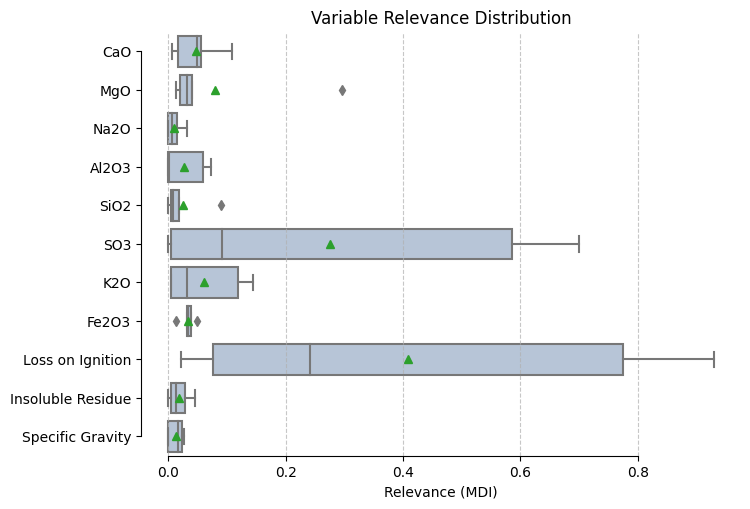

<IPython.core.display.Javascript object>

In [21]:
warnings.filterwarnings("ignore")
plt.figure(figsize=(10, 5.5))
sns.boxplot(data=df_importances, orient="h", color="lightsteelblue", saturation=0.7, showmeans=True)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.show()


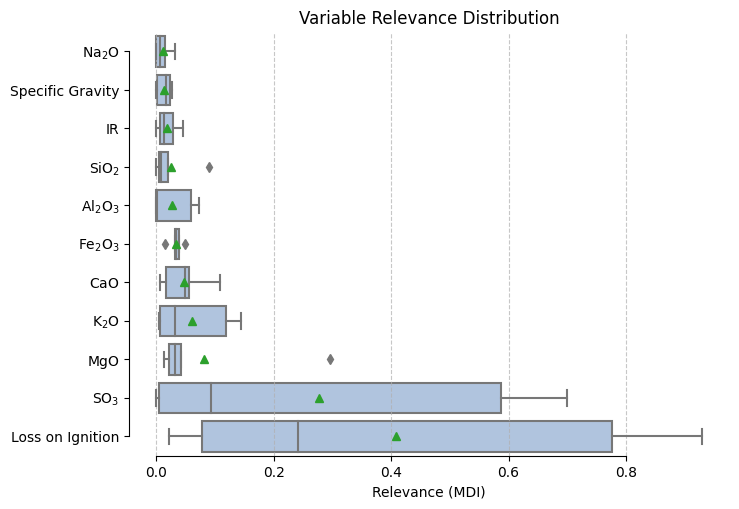

<IPython.core.display.Javascript object>

In [22]:
# Calculate the means of the importance scores
mean_importances = df_importances.mean()

# Sort the features by their mean relevance
sorted_features = mean_importances.sort_values()

# Re-order the DataFrame according to the sorted features
df_importances_sorted = df_importances[sorted_features.index]

# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
df_importances_sorted_plot = df_importances_sorted.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=df_importances_sorted_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (MDI)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_207_at_cm_btiss_random_forest_scpm_best_dist_var_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [23]:
df_importances

,CaO,MgO,Na2O,Al2O3,SiO2,SO3,K2O,Fe2O3,Loss on Ignition,Insoluble Residue,Specific Gravity
Importances - 0,0.017002,0.031423,0.031450,0.072181,0.019127,0.586354,0.144069,0.031816,0.021154,0.028921,0.016502
Importances - 1,0.048212,0.020618,0.014737,0.000000,0.000000,0.700092,0.031829,0.038289,0.076965,0.045658,0.023601
Importances - 2,0.056154,0.296211,0.006245,0.059375,0.090180,0.092151,0.118681,0.013789,0.241178,0.000000,0.026037
Importances - 3,0.108099,0.041273,0.000000,0.000663,0.004998,0.003852,0.003968,0.049032,0.775498,0.012546,0.000072
Importances - 4,0.005787,0.012643,0.000000,0.000000,0.007311,0.000000,0.005261,0.033909,0.929651,0.005438,0.000000


<IPython.core.display.Javascript object>

In [24]:
df_importances.describe().T

,count,mean,std,min,25%,50%,75%,max
CaO,5.0,0.047051,0.040052,0.005787,0.017002,0.048212,0.056154,0.108099
MgO,5.0,0.080433,0.121108,0.012643,0.020618,0.031423,0.041273,0.296211
Na2O,5.0,0.010486,0.013186,0.000000,0.000000,0.006245,0.014737,0.031450
Al2O3,5.0,0.026444,0.036192,0.000000,0.000000,0.000663,0.059375,0.072181
SiO2,5.0,0.024323,0.037479,0.000000,0.004998,0.007311,0.019127,0.090180
SO3,5.0,0.276490,0.339195,0.000000,0.003852,0.092151,0.586354,0.700092
K2O,5.0,0.060761,0.066026,0.003968,0.005261,0.031829,0.118681,0.144069
Fe2O3,5.0,0.033367,0.012803,0.013789,0.031816,0.033909,0.038289,0.049032
Loss on Ignition,5.0,0.408889,0.416604,0.021154,0.076965,0.241178,0.775498,0.929651
Insoluble Residue,5.0,0.018513,0.018671,0.000000,0.005438,0.012546,0.028921,0.045658


<IPython.core.display.Javascript object>

In [25]:
df_importances.mean(axis=0)

CaO                  0.047051
MgO                  0.080433
Na2O                 0.010486
Al2O3                0.026444
SiO2                 0.024323
SO3                  0.276490
K2O                  0.060761
Fe2O3                0.033367
Loss on Ignition     0.408889
Insoluble Residue    0.018513
Specific Gravity     0.013242
dtype: float64

<IPython.core.display.Javascript object>

In [26]:
df_importances.std(axis=0, ddof=0)

CaO                  0.035824
MgO                  0.108323
Na2O                 0.011794
Al2O3                0.032371
SiO2                 0.033522
SO3                  0.303385
K2O                  0.059056
Fe2O3                0.011451
Loss on Ignition     0.372622
Insoluble Residue    0.016700
Specific Gravity     0.011229
dtype: float64

<IPython.core.display.Javascript object>

In [27]:
df_copy.nunique()

Date                 844
CaO                  632
MgO                  211
Na2O                  12
Al2O3                297
SiO2                 591
SO3                  205
K2O                   49
Fe2O3                182
Loss on Ignition     414
Insoluble Residue    191
Specific Gravity      21
dtype: int64

<IPython.core.display.Javascript object>

In [28]:
pipeline.named_steps

{'imputer': SimpleImputer(strategy='median'),
 'estimator': RandomForestRegressor(max_depth=3, n_estimators=5, random_state=47)}

<IPython.core.display.Javascript object>

In [29]:
from sklearn.inspection import permutation_importance

<IPython.core.display.Javascript object>

In [30]:
# Initialize lists to store importance results
mdi_importances = []
perm_importances = []

# Compute feature importances
for i, (train_idx, test_idx) in enumerate(cv.split(x, y)):
    pipeline.fit(x.iloc[train_idx], y[train_idx])

    # Extract the trained model
    model = pipeline.named_steps["estimator"]
    imputer = pipeline.named_steps["imputer"]
    # Compute MDI importance
    mdi_importances.append(model.feature_importances_)

    # Compute permutation importance
    result = permutation_importance(
        model,
        imputer.transform(x.iloc[test_idx]),
        y[test_idx],
        n_repeats=10,
        random_state=SEED,
        n_jobs=-1,
        scoring="r2",
    )
    perm_importances.append(result.importances_mean)

<IPython.core.display.Javascript object>

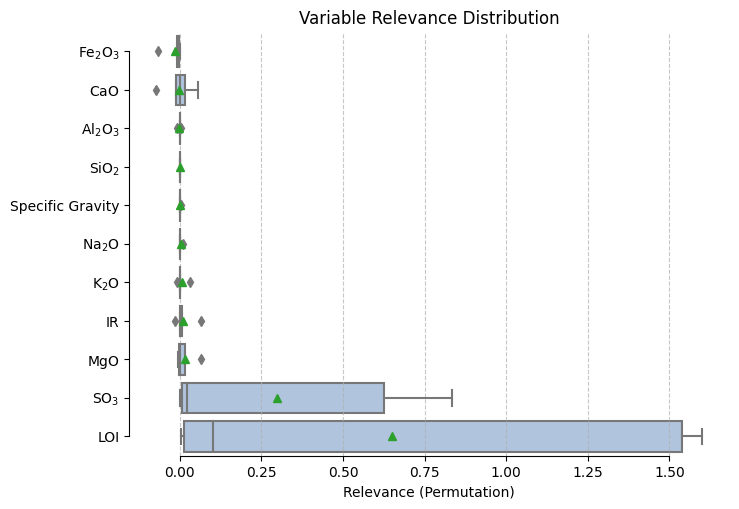

<IPython.core.display.Javascript object>

In [31]:
# Convert lists to DataFrames
mdi_importances_df = pd.DataFrame(mdi_importances, columns=x.columns)
perm_importances_df = pd.DataFrame(perm_importances, columns=x.columns)


# Calculate the mean importance for each feature
mean_importances = perm_importances_df.mean().sort_values()

# Reorder the DataFrame columns based on mean importance
perm_importances_df = perm_importances_df[mean_importances.index]

perm_importances_df = perm_importances_df.rename(columns={"Loss on Ignition": "LOI"})


# Backup the original backend
original_backend = plt.get_backend()

# Use Matplotlib's default backend
# plt.switch_backend("agg")  # or any backend you prefer

# Update font settings to default
plt.rcParams.update(
    {
        "font.family": "sans-serif",
        "font.sans-serif": ["DejaVu Sans"],
        "font.size": 10,
        "text.usetex": False,  # Use MathText, not LaTeX
    }
)


# Convert chemical formulas using MathText syntax
perm_importances_df_plot = perm_importances_df.rename(
    columns={
        "K2O": r"$\mathrm{K_2O}$",
        "Free CaO": r"Free $\mathrm{CaO}$",
        "Total C2S": r"Total $\mathrm{C_2S}$",
        "Na2O": r"$\mathrm{Na_2O}$",
        "CaO": r"$\mathrm{CaO}$",
        "SiO2": r"$\mathrm{SiO_2}$",
        "MgO": r"$\mathrm{MgO}$",
        "Fe2O3": r"$\mathrm{Fe_2O_3}$",
        "Al2O3": r"$\mathrm{Al_2O_3}$",
        "Total C3S": r"Total $\mathrm{C_3S}$",
        "C3A": r"$\mathrm{C_3A}$",
        "C4AF": r"$\mathrm{C_4AF}$",
        "LOI": "LOI",
        "SO3": r"$\mathrm{SO_3}$",
        "Insoluble Residue": "IR",
        "TiO2": r"$\mathrm{TiO_2}$",
    }
)

plt.figure(figsize=(10, 5.5))
sns.boxplot(
    data=perm_importances_df_plot,
    orient="h",
    color="lightsteelblue",
    saturation=1,
    showmeans=True,
)
sns.despine(trim=True, left=False)
plt.xlabel("Relevance (Permutation)")
plt.title("Variable Relevance Distribution")
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.subplots_adjust(left=0.3)
plt.savefig(
    "ecics_207_at_cm_btiss_random_forest_scpm_best_dist_var_perm_relevance.png",
    dpi=300,
    bbox_inches="tight",
)
plt.show()


# Step 3: Reset all rcParams to their default values
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
plt.rcdefaults()

# Switch back to the original backend
plt.switch_backend(original_backend)

In [32]:
perm_importances_df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
Fe2O3,5.0,-0.02,0.03,-0.07,-0.01,-0.00,-0.00,0.00
CaO,5.0,-0.00,0.05,-0.07,-0.01,0.00,0.02,0.06
Al2O3,5.0,-0.00,0.00,-0.01,-0.00,0.00,0.00,0.00
SiO2,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Specific Gravity,5.0,0.00,0.00,-0.00,0.00,0.00,0.00,0.00
Na2O,5.0,0.00,0.00,0.00,0.00,0.00,0.00,0.01
K2O,5.0,0.01,0.02,-0.01,0.00,0.00,0.00,0.03
Insoluble Residue,5.0,0.01,0.03,-0.02,0.00,0.00,0.01,0.06
MgO,5.0,0.01,0.03,-0.01,-0.00,-0.00,0.02,0.06
SO3,5.0,0.30,0.40,0.00,0.01,0.02,0.63,0.83


<IPython.core.display.Javascript object>

In [33]:
perm_importances_df

,Fe2O3,CaO,Al2O3,SiO2,Specific Gravity,Na2O,K2O,Insoluble Residue,MgO,SO3,LOI
0,-0.003142,0.055584,-0.000035,0.000000,0.000000,0.000000,0.000000,0.005371,0.015723,0.832453,0.012788
1,-0.067333,0.016168,0.000000,0.000000,0.003985,0.010435,0.032457,-0.016457,-0.005301,0.626588,0.101126
2,0.000000,-0.071655,-0.008300,0.001567,0.001063,0.000000,0.000000,0.000000,0.064635,0.020878,0.002257
3,-0.009070,-0.012791,0.002296,0.000000,-0.000331,0.000000,-0.007648,0.064812,-0.001337,0.006943,1.599810
4,-0.001708,0.000000,0.000000,0.001141,0.000000,0.000000,0.001334,0.000349,-0.000020,0.000000,1.538563


<IPython.core.display.Javascript object>

In [34]:
perm_importances_df.mean(axis=0)

Fe2O3               -0.016251
CaO                 -0.002539
Al2O3               -0.001208
SiO2                 0.000542
Specific Gravity     0.000943
Na2O                 0.002087
K2O                  0.005228
Insoluble Residue    0.010815
MgO                  0.014740
SO3                  0.297373
LOI                  0.650909
dtype: float64

<IPython.core.display.Javascript object>

In [35]:
perm_importances_df.std(axis=0, ddof=0)

Fe2O3                0.025723
CaO                  0.041513
Al2O3                0.003657
SiO2                 0.000677
Specific Gravity     0.001592
Na2O                 0.004174
K2O                  0.013979
Insoluble Residue    0.027984
MgO                  0.025955
SO3                  0.358866
LOI                  0.750806
dtype: float64

<IPython.core.display.Javascript object>